# Regression Model with Text Data | MSCI:6100

**Spring 2021 | Instructor: Qihang Lin | Mar 1, 2021**

<img src=https://miro.medium.com/max/960/1*LEmBCYAttxS6uI6rEyPLMQ.png width="400">



In this lecture, we will focus on the task of predicting continuous outcomes using text data (**regression task**).
- Stock price
- Box office revenue 
- Star rating

The basic steps of text regression are similar to those in text classification. The main differences include:

- Use LASSO model instead of logistic regression
- Use root mean squared error to measure the prediction performance

## Linear Regression

* Vectorization of a document: $\mathbf{x}=(x_1,x_2,\dots,x_n)$ 
    * $\mathbf{x}$ is a row in DTM.
    
* Each document corresponds to a continuous outcome, denoted by $y$.
    * For example, $y=$movie's revenue.
    
* Prediction by a linear model: 
    * $y=\beta_0+\beta_1x_1+\beta_2x_2+\cdots+\beta_nx_n$
* Coefficients: 
    * Intercept: $\beta_0$ 
    * Slopes: $\mathbf{\beta}=(\beta_1,\beta_2,\dots,\beta_n)$

* Impact of coefficients: 
    * $\beta_i>0$: A document with a high frequency in term $i$ corresponds to a large $y$. 
    * $\beta_i<0$: A document with a high frequency in term $i$ corresponds to a small $y$.
    * $\beta_i=0$: Term $i$ has no impact on $y$.

## LASSO 

* LASSO mean **least absolute shrinkage and selection operator**.


* Just like l1-regularized logistic regression, LASSO makes slope $\beta_i=0$ for non-significant variables and thus remove them from the model. This helps reduce the number of variables and avoid overfitting.


* Its math model: https://scikit-learn.org/stable/modules/linear_model.html#lasso


* Just like l1-regularized logistic regression, a **regularization parameter $\alpha$** must be provided when building a LASSO model. 


* As $\alpha$ increases, $\mathbf{\beta}$ becomes more sparse with more $\beta_i$ being zero.

## Dataset Preparation

We will apply LASSO to predict star ratings of reviews on dresses. The following code loads the data, where column "Rating" contains star ratings and column "Review.Text" contains review texts.

In [1]:
import pandas as pd
import re
df = pd.read_csv("classdata/DressReviews.csv")
df["Rating"].value_counts()
df=df[["Review.Text","Rating"]]
#Some review texts are NaN and must be dropped.
df.dropna(axis=0, how='any', inplace=True)
df.head()

,Review.Text,Rating
0,"I love, love, love this absolutely stunning dr...",3
1,I was surprised at the positive reviews for th...,1
2,"Couldn't make it work, even belted. ivory colo...",2
3,This dress hangs like a sack. it really needs ...,1
4,Soooo disappointed in this dress. the colors a...,2


In [2]:
#Split the data
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.33)
df_train.reset_index(drop=True,inplace=True)
df_test.reset_index(drop=True,inplace=True)

## Feature Engineering

We create the DTMs for training and testing sets as follows.

In [3]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk 

stemmer = nltk.stem.SnowballStemmer("english", ignore_stopwords=True)
class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedTfidfVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

nltk_stopwords = nltk.corpus.stopwords.words("english") 

vectorizer=StemmedTfidfVectorizer(stop_words=nltk_stopwords,
                                  use_idf=True,
                                  smooth_idf=True,
                                  norm=None)

train_x = vectorizer.fit_transform(df_train["Review.Text"])
train_y = df_train["Rating"]
print(train_x.shape)

test_x = vectorizer.transform(df_test["Review.Text"])
test_y = df_test["Rating"]
print(test_x.shape)

(1572, 3288)
(775, 3288)


In [4]:
#Rescale columns. No need to do this if the rows of DTMs are normalized.
from sklearn.preprocessing import MaxAbsScaler
scaler = MaxAbsScaler()
scaler.fit(train_x)
train_x=scaler.transform(train_x)
test_x=scaler.transform(test_x)

## Model Training

In [5]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.01, #Regularization parameter.
              max_iter=10000
              )
lasso.fit(train_x,train_y)

Lasso(alpha=0.01, max_iter=10000)

More options: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

In [6]:
#Slope betas
lasso.coef_

array([-0.,  0.,  0., ..., -0., -0., -0.])

In [7]:
#Intercept beta0
lasso.intercept_

3.2878014686377606

In [8]:
#Check the number of non-zero slopes, which is also the number of terms selected by the model.  
import numpy as np
np.count_nonzero(lasso.coef_)

44

In [9]:
#Check the percentage of non-zero slopes
np.count_nonzero(lasso.coef_)/len(lasso.coef_)

0.01338199513381995

## Descriptive Analytics

We can identify the terms that have the largest positive and negative impacts to star ratings.

In [10]:
dfbeta = pd.DataFrame({'Term': vectorizer.get_feature_names(),
                       'Beta': lasso.coef_
                     })
dfbeta.sort_values(by="Beta",inplace=True,ascending=False)
dfbeta.reset_index(inplace=True,drop=True)
dfbeta.head(10)

,Term,Beta
0,perfect,1.492152
1,comfort,1.394068
2,love,0.746213
3,great,0.643667
4,compliment,0.624529
5,wear,0.426081
6,beauti,0.331059
7,spring,0.305546
8,bit,0.273440
9,fit,0.245235


In [11]:
dfbeta.sort_values(by="Beta",inplace=True,ascending=True)
dfbeta.reset_index(inplace=True,drop=True)
dfbeta.head(10)

,Term,Beta
0,return,-0.984547
1,unflatt,-0.870004
2,disappoint,-0.713586
3,cheap,-0.626329
4,back,-0.500017
5,huge,-0.481175
6,excit,-0.364772
7,look,-0.354933
8,sad,-0.331298
9,howev,-0.315660


## Predictive Analytics

In [12]:
#Apply the model to the reviews testing set and predict the star ratings
lasso.predict(test_x)[0:10]

array([3.23671664, 3.79907008, 3.26777553, 4.71509583, 3.23893064,
       3.97169802, 3.63914817, 3.37485959, 4.61308739, 4.82859485])

## Performance Metric

**Root Mean Squared Error**(RMSE): A small RMSE means a high prediction accuracy.

| | True Y | Pred Y |
| --- | --- | --- |
| 0 | $y_0$ | $\hat y_0$ |
| 1 | $y_1$ | $\hat y_1$ |
| | $\vdots$| $\vdots$ |
| N-1 | $y_{N-1}$ | $\hat y_{N-1}$ |

$$\text{RMSE}(y, \hat{y}) = \sqrt{\frac{ (y_0 - \hat{y}_0)^2+(y_1 - \hat{y}_1)^2+\dots+(y_{N-1} - \hat{y}_{N-1})^2}{N} }$$



More performance metrics: https://scikit-learn.org/stable/modules/model_evaluation.html

In [13]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(train_y,lasso.predict(train_x),squared=False))
print()
print(mean_squared_error(test_y,lasso.predict(test_x),squared=False))

1.0760078440630143

1.1169886099092936


Here, **squared=False** makes **mean_squared_error** return RMSE. If **squared=True**, it returns **mean squared error (MSE)**, which is a different performance metric for regression task:

$$MSE=RMSE^2$$

## Select Regularization Parameter by Cross Validation

The parameter $\alpha$ can be selected by $K$-fold cross validation with a procedure similar to that for l1-regularized logistic regression.  

To make sure the candidate values for $\alpha$ have diversified scales, we generate the candidates spaced evenly on a logarithmic scale.

The following code generate 10 candidates for $\alpha$ between $10^{-3}$ and $10^{0}$ spaced evenly on a logarithmic scale.

In [14]:
import numpy as np
alphaList = np.logspace(start=-3,stop=0,num=10)
alphaList

array([0.001     , 0.00215443, 0.00464159, 0.01      , 0.02154435,
       0.04641589, 0.1       , 0.21544347, 0.46415888, 1.        ])

In [15]:
from sklearn.linear_model import LassoCV
lasso = LassoCV(alphas=alphaList,  
                   cv=5,       #Number of folds, i.e., K
                   max_iter=1000)
lasso.fit(train_x, train_y)

LassoCV(alphas=array([0.001     , 0.00215443, 0.00464159, 0.01      , 0.02154435,
       0.04641589, 0.1       , 0.21544347, 0.46415888, 1.        ]),
        cv=5)

In [16]:
train_x.shape

(1572, 3288)

Mean square error is used as the peformance metric to select $\alpha$

More options: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html

In [17]:
#The values of alpha
lasso.alphas_

array([1.        , 0.46415888, 0.21544347, 0.1       , 0.04641589,
       0.02154435, 0.01      , 0.00464159, 0.00215443, 0.001     ])

In [18]:
#The MSE for each alpha in K folds.
pd.DataFrame(lasso.mse_path_)

,0,1,2,3,4
0,1.858565,1.856515,1.681165,1.844090,1.897970
1,1.858565,1.856515,1.681165,1.844090,1.897970
2,1.858565,1.856515,1.681165,1.844090,1.897970
3,1.858565,1.856515,1.681165,1.844090,1.897970
4,1.781279,1.724323,1.587105,1.738906,1.768585
5,1.541706,1.441899,1.382339,1.473966,1.525415
6,1.319076,1.161772,1.164415,1.251283,1.258654
7,1.153450,1.019720,1.030318,1.145698,1.107931
8,1.058317,0.994872,1.007834,1.146540,1.062429
9,1.169794,1.157560,1.062615,1.297555,1.149229


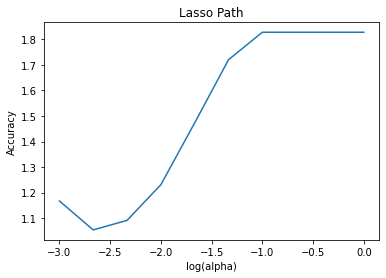

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(np.log10(lasso.alphas_), lasso.mse_path_.mean(axis=1))
plt.xlabel('log(alpha)')
plt.ylabel('Accuracy')
plt.title('Lasso Path')
plt.axis('tight')
plt.show()

In [20]:
#This is the best value of alpha among the candidates.
bestalpha=lasso.alpha_
bestalpha

0.0021544346900318843

Evaluate the performance using the best $\alpha$.

In [21]:
print(mean_squared_error(train_y,lasso.predict(train_x),squared=False))
print()
print(mean_squared_error(test_y,lasso.predict(test_x),squared=False))

0.8241301945343834

1.0165516131639243
